# WSI 24L
## Ćwiczenie 3 - dwuosobowe gry deterministyczne
### Igor Szabłowski

In [1]:
from two_player_games.games.dots_and_boxes import DotsAndBoxes, DotsAndBoxesState
import numpy as np
from copy import deepcopy
from two_player_games.player import Player
import seaborn as sns

### Implementacja algorytmu
Zaimplementowany został algorytm minimax z obcinaniem $\alpha - \beta$. Dla różnych ruchów o tej samej jakości algorytm zwraca losowy z nich. Metoda przyjmuje jako argumenty stan w jakim rozgrywka się znajduje, głębokość na jaką ma sprawdzać ruchy, czy gracz wykonujący aktualny ruch jest maksymalizujący czy minimalizujący, $\alpha$ (startowo $-\inf$), $\beta$ (startowo $\inf$), funkcje oceny planszy oraz gracza który jest maksymalizujący.

In [2]:
class MiniMax:

    @staticmethod
    def alphabeta(state: DotsAndBoxesState, depth, is_maximizing, alpha, beta, eval, maximizing_player):
        if depth == 0 or state.is_finished():
            return eval(state, maximizing_player), None

        if is_maximizing:
            best_moves_value = -np.inf
            moves = state.get_moves()
            best_moves = []
            for move in moves:
                new_state = deepcopy(state)
                new_state_after_move = new_state.make_move(move)
                is_maximizing = new_state.get_current_player().char == new_state_after_move.get_current_player().char
                value, _ = MiniMax.alphabeta(new_state_after_move, depth-1, is_maximizing, alpha, beta, eval, maximizing_player)
                if value > best_moves_value:
                    best_moves_value = value
                    best_moves.clear()
                    best_moves.append(move)
                elif value == best_moves_value:
                    best_moves.append(move)
                if best_moves_value > beta:
                    break
                alpha = max(alpha, best_moves_value)
            return best_moves_value, best_moves
        else:
            best_moves_value = np.inf
            moves = state.get_moves()
            best_moves = []
            for move in moves:
                new_state = deepcopy(state)
                new_state_after_move = new_state.make_move(move)
                is_maximizing = not new_state.get_current_player().char == new_state_after_move.get_current_player().char
                value, _ = MiniMax.alphabeta(new_state_after_move, depth-1, is_maximizing, alpha, beta, eval, maximizing_player)
                if value < best_moves_value:
                    best_moves_value = value
                    best_moves.clear()
                    best_moves.append(move)
                elif value == best_moves_value:
                    best_moves.append(move)
                if best_moves_value < alpha:
                    break
                beta = min(beta, best_moves_value)
            return best_moves_value, best_moves

In [13]:
class MiniMax:

    @staticmethod
    def alphabeta(state: DotsAndBoxesState, depth, is_maximizing, alpha, beta, eval, maximizing_player):
        if depth == 0 or state.is_finished():
            return eval(state, maximizing_player), None

        if is_maximizing:
            max_value = -np.inf
            best_moves = []
            moves = state.get_moves()
            
            for move in moves:
                new_state = deepcopy(state)
                new_state_after_move = new_state.make_move(move)
                is_next_player_maximizing = new_state.get_current_player().char == new_state_after_move.get_current_player().char
                value, _  = MiniMax.alphabeta(new_state_after_move, depth-1, is_next_player_maximizing, alpha, beta, eval, maximizing_player)
                
                if value > max_value:
                    max_value = value
                    best_moves.clear()
                    best_moves.append(move)
                
                elif value == max_value:
                    best_moves.append(move)
                
                alpha = max(alpha, max_value)

                if alpha >= beta:
                    break
            return max_value, best_moves
        
        else:
            min_value = np.inf
            best_moves = []
            moves = state.get_moves()

            for move in moves:
                new_state = deepcopy(state)
                new_state_after_move = new_state.make_move(move)
                is_next_player_maximizing = new_state.get_current_player().char == new_state_after_move.get_current_player().char
                value, _ = MiniMax.alphabeta(new_state_after_move, depth-1, not is_next_player_maximizing, alpha, beta, eval, maximizing_player)

                if value < min_value:
                    min_value = value
                    best_moves.clear()
                    best_moves.append(move)
                
                elif value == min_value:
                    best_moves.append(move)

                if alpha > beta:
                    break

                beta = min(beta, min_value)
            return min_value, best_moves

Zadany algorytm będzie testowany na grze DotsAndBoxes której implementacje można znaleźć [tutaj](https://github.com/lychanl/two-player-games).\
Poniżej widnieją implementacje funkcji oceny planszy oraz samej rozgrywki pomiędzy dwoma graczami używającymi minimax z zadanymi głębokościami. Funkcja oceny uwzględnia różnice ilości punktów graczy. Funkcja gry wykonuje natomiast $i$ zadanych gier, zmieniając kolejność rozpoczynającego gracza co każdą grę.

In [14]:
def evaluate_dnb_state(state: DotsAndBoxesState, maximizing_player: Player):
    player = state.get_players()
    scores = state.get_scores()
    return scores[player[0]]-scores[player[1]] if player[0].char == maximizing_player.char else scores[player[1]]-scores[player[0]]

def game(i, depth_0, depth_1):
    player0 = Player('0')
    player1 = Player('1')
    wins = {'0': 0, '1': 0}
    depths = {player0: depth_0, player1: depth_1}

    for j in range(i):
        if j%2:
            game = DotsAndBoxes(3, player0, player1)
        else:
            game = DotsAndBoxes(3, player1, player0)

        while not game.is_finished():
            current_player = game.get_current_player()
            _, best_moves = MiniMax.alphabeta(game.state, depths[current_player], True, -np.inf, np.inf, evaluate_dnb_state, current_player)
            try:
                game.make_move(np.random.choice(best_moves))
            except ValueError:
                game.make_move(np.random.choice(game.get_moves()))
        wins[game.get_winner().char] += 1
    return wins


{'0': 9, '1': 1}

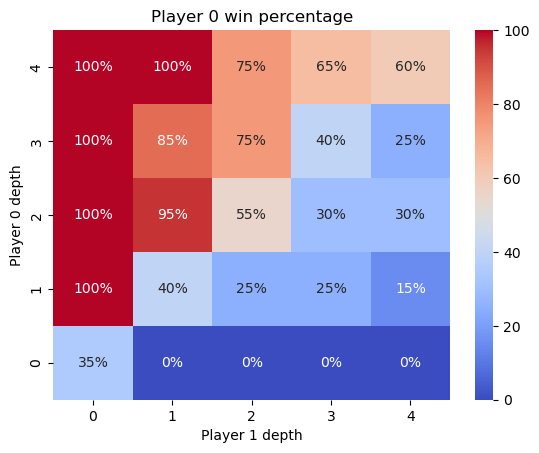

In [15]:
data = []
max_depth = 4
for i in range(max_depth+1):
    data_row = []
    for j in range(max_depth+1):
        wins = game(20, i, j)
        data_row.append(wins['0']/(wins['1']+wins['0'])*100)
    data.insert(0, data_row)
annot_data = [[f'{val:.0f}%' for val in row] for row in data]
heat_map = sns.heatmap(data, annot=annot_data, fmt='', yticklabels=np.arange(max_depth, -1, -1), xticklabels=np.arange(max_depth+1), cmap='coolwarm');
heat_map.set_ylabel('Player 0 depth');
heat_map.set_xlabel('Player 1 depth');
heat_map.set_title('Player 0 win percentage');
